In [0]:
!pip install azure-storage-blob

  Using cached azure_storage_blob-12.20.0-py3-none-any.whl (392 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
  Using cached azure_core-1.30.1-py3-none-any.whl (193 kB)
  Using cached typing_extensions-4.11.0-py3-none-any.whl (34 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2caf744e-94ab-4b64-8049-fdc777a78be5
    Can't uninstall 'typing_extensions'. No files were found to uninstall.

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [0]:
from azure.storage.blob import BlobServiceClient
storage_account_name = "pysparkstorageaccnt"
storage_account_access_key = "uXDKIkT9KnlL5CSHFqu9auafAdlRXFPDFvWICxSrBvKd6CksPLgNEuzQnlWscUJXmm6kh0xwCx/D+AStSzOnCQ=="
container_name = "capstonejs"
mount_point = "/mnt/capstonejs"

In [0]:
if any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.unmount(mount_point)
dbutils.fs.mount(
    source = "wasbs://" + container_name + "@" + storage_account_name + ".blob.core.windows.net",
    mount_point = mount_point,
    extra_configs = {"fs.azure.account.key." + storage_account_name + ".blob.core.windows.net": storage_account_access_key})


---------------------------------------------------------------------------
ExecutionError                            Traceback (most recent call last)
File <command-1890957258638483>, line 2
      1 # dbutils.fs.unmount(mount_point)
----> 2 dbutils.fs.mount(
      3     source = "wasbs://" + container_name + "@" + storage_account_name + ".blob.core.windows.net",
      4     mount_point = mount_point,
      5     extra_configs = {"fs.azure.account.key." + storage_account_name + ".blob.core.windows.net": storage_account_access_key})

File /databricks/python_shell/dbruntime/dbutils.py:362, in DBUtils.FSHandler.prettify_exception_message.<locals>.f_with_exception_handling(*args, **kwargs)
    360 exc.__context__ = None
    361 exc.__cause__ = None
--> 362 raise exc

ExecutionError: An error occurred while calling o382.mount.
: java.rmi.RemoteException: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/capstonejs; nested exception is: 
	java.lang.Illeg

In [0]:
dbutils.fs.ls("/mnt/capstonejs")

[FileInfo(path='dbfs:/mnt/capstonejs/dataset/', name='dataset/', size=0, modificationTime=1716286123000),
 FileInfo(path='dbfs:/mnt/capstonejs/models/', name='models/', size=0, modificationTime=1716286450000)]

In [0]:
import pyspark
from pyspark.sql import SparkSession
conf=pyspark.SparkConf()
spark = SparkSession.builder.config(conf=conf).appName('Test').getOrCreate()

In [0]:
wine_df = spark\
.read\
.option("inferSchema", "true")\
.option("header", "true")\
.csv("/mnt/capstonejs/dataset/raw/winequality-red.csv")

In [0]:
wine_df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|              0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|              0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|              0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0

In [0]:
wine_df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



## Null values

In [0]:
from pyspark.sql.functions import col,isnan, when, count
wine_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in wine_df.columns]
   ).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+



## Vector Assembler

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
assembler = VectorAssembler(inputCols=wine_df.columns, outputCol="features")
df_vectorized = assembler.transform(wine_df)

## Correlation with quality column

In [0]:
from pyspark.ml.stat import Correlation

correlation_matrix = Correlation.corr(df_vectorized, "features").head()
corr_matrix = correlation_matrix[0].toArray()

# Print the correlation matrix
print("Correlation Matrix:")
for i, col in enumerate(wine_df.columns):
    for j, row in enumerate(wine_df.columns):
        if row == "quality":
            print(f"{col} vs {row}: {corr_matrix[i][j]}")

Correlation Matrix:
fixed acidity vs quality: 0.12405164911322414
volatile acidity vs quality: -0.3905577802640099
citric acid vs quality: 0.22637251431804165
residual sugar vs quality: 0.013731637340066424
chlorides vs quality: -0.12890655993005293
free sulfur dioxide vs quality: -0.050656057244276194
total sulfur dioxide vs quality: -0.18510028892653863
density vs quality: -0.1749192277833506
pH vs quality: -0.057731391205382364
sulphates vs quality: 0.2513970790692617
alcohol vs quality: 0.4761663240011388
quality vs quality: 1.0


## Scaling

In [0]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Fit the StandardScaler to the data
scaler_model = scaler.fit(df_vectorized)

# Transform the data
scaled_df = scaler_model.transform(df_vectorized)

## Plots

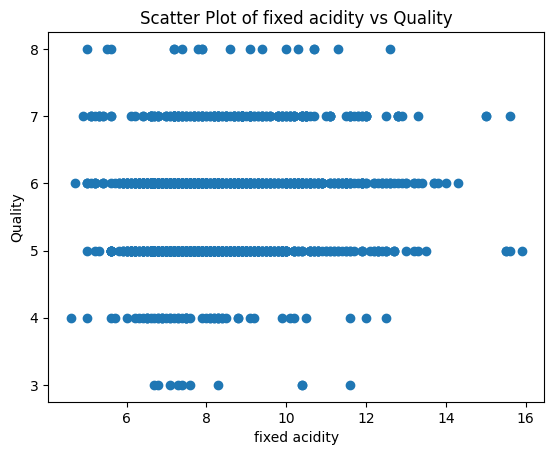

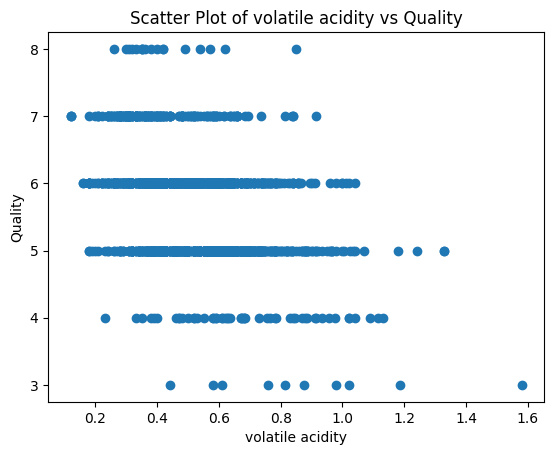

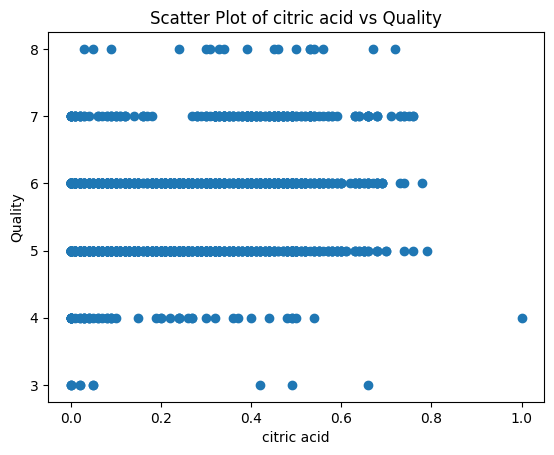

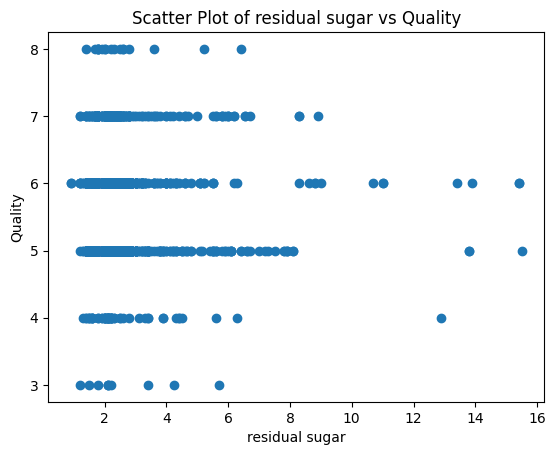

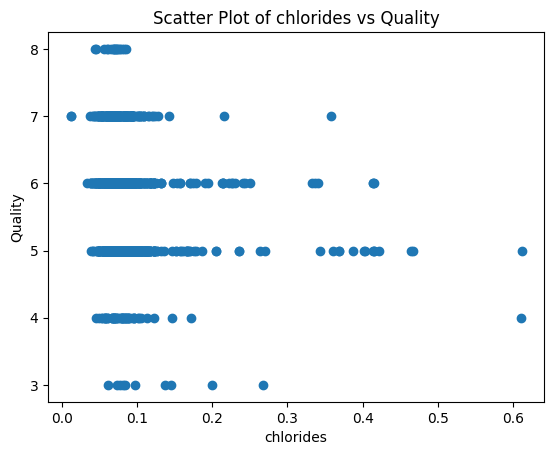

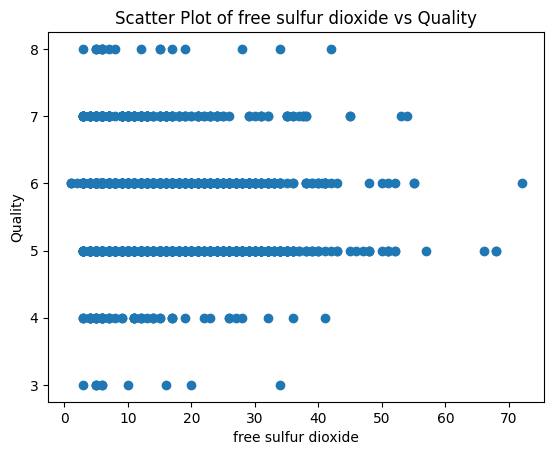

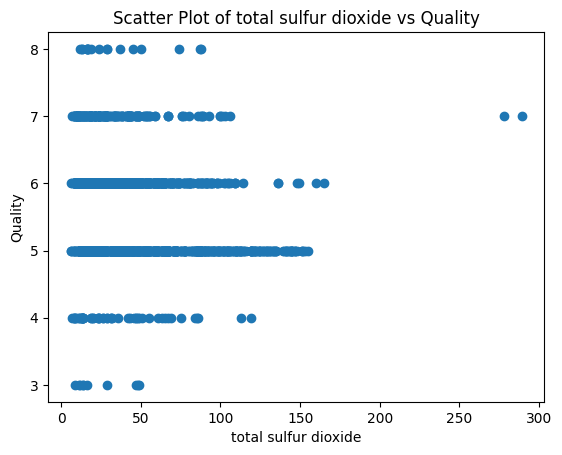

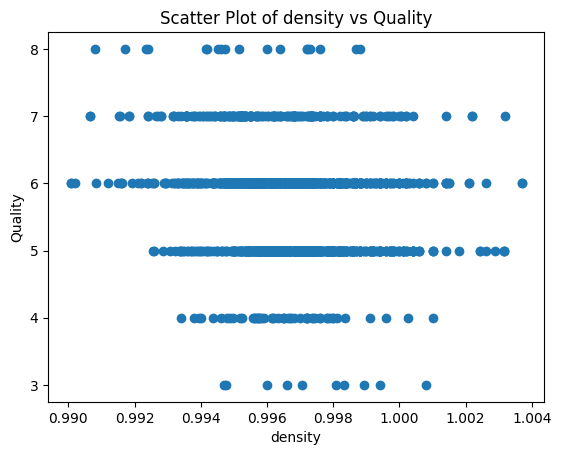

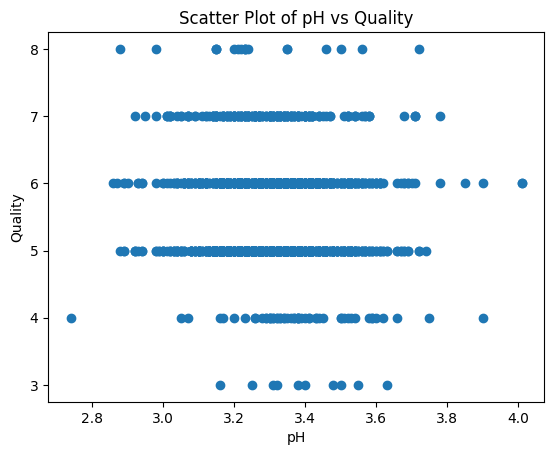

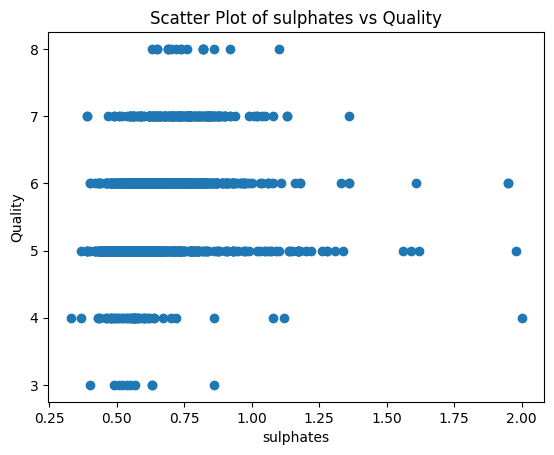

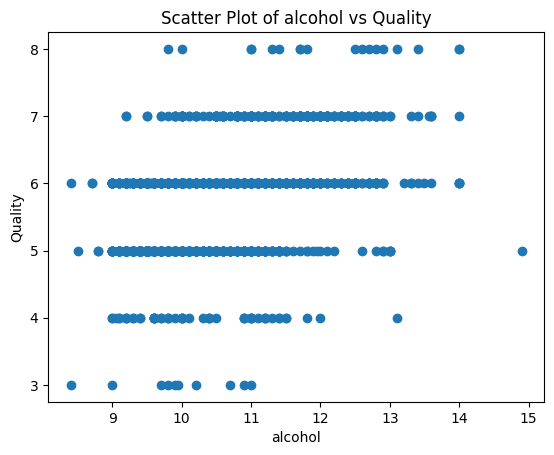

In [0]:
import matplotlib.pyplot as plt
quality_values = wine_df.select("quality").rdd.flatMap(lambda x: x).collect()

# Plotting
for col_name in wine_df.columns[:-1]:  # Exclude "quality" column
    x_values = wine_df.select(col_name).rdd.flatMap(lambda x: x).collect()
    plt.scatter(x_values, quality_values)
    plt.xlabel(col_name)
    plt.ylabel("Quality")
    plt.title(f"Scatter Plot of {col_name} vs Quality")
    plt.show()

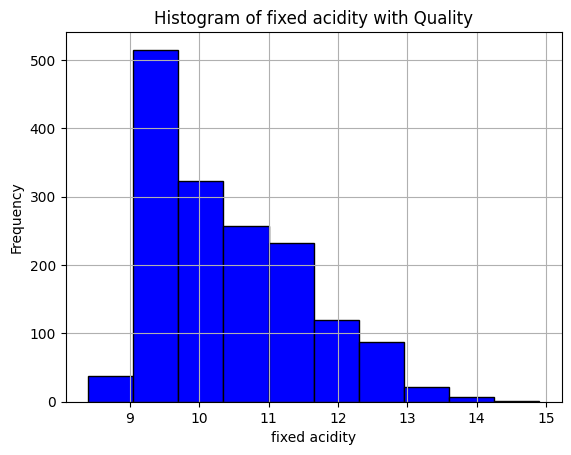

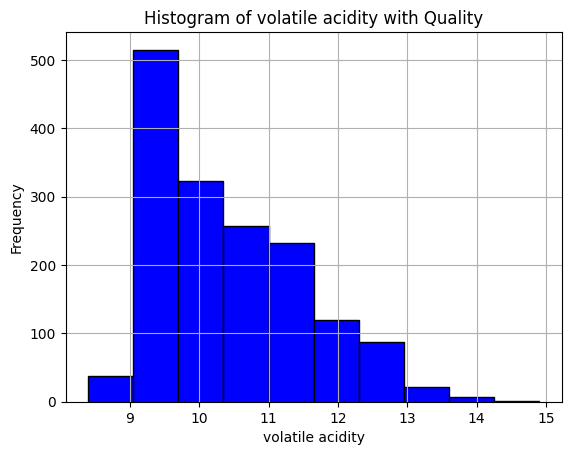

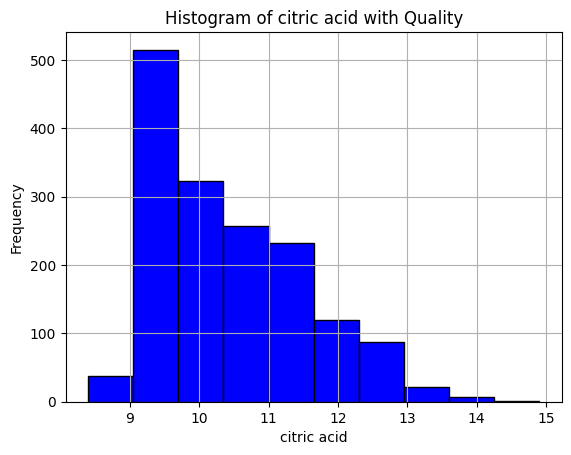

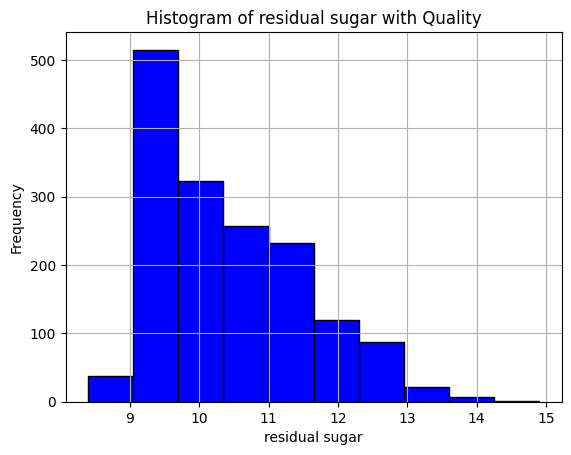

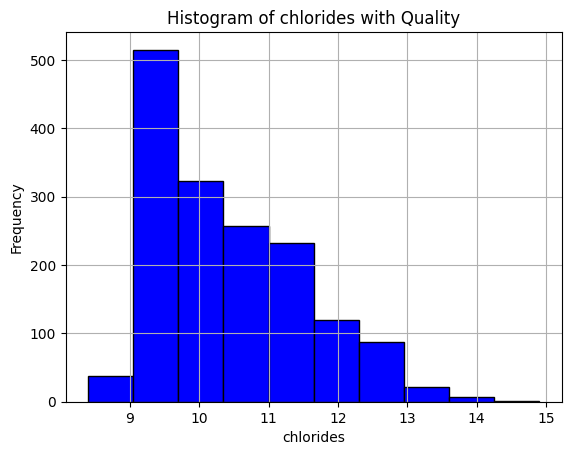

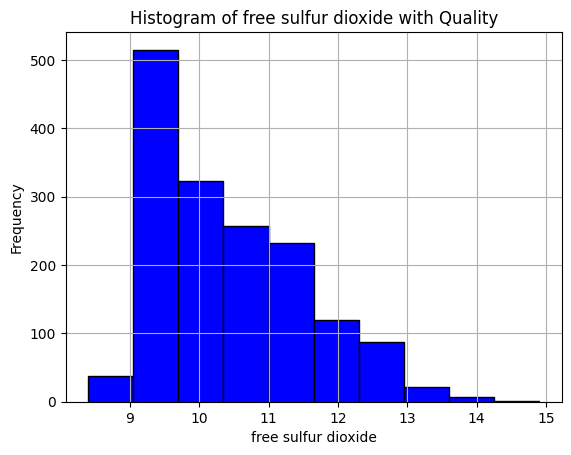

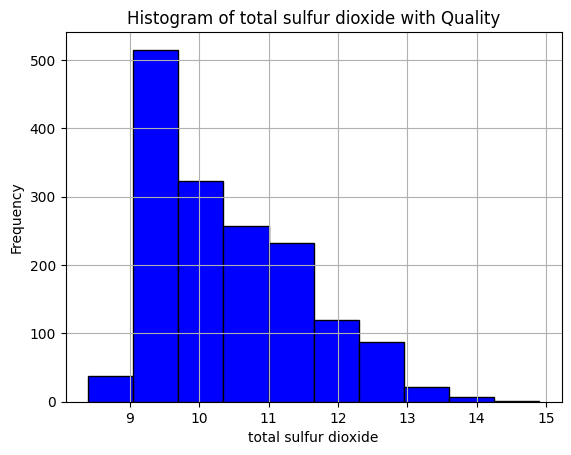

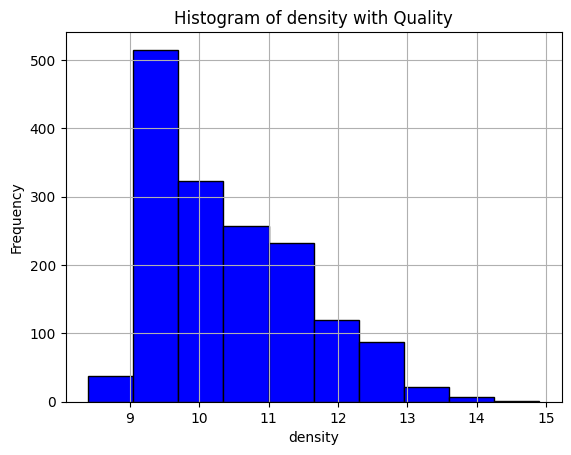

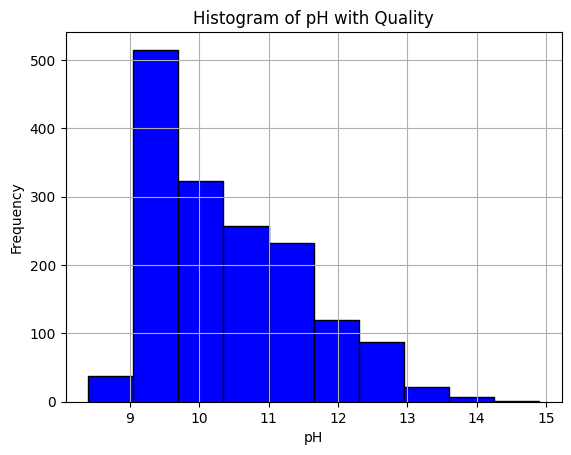

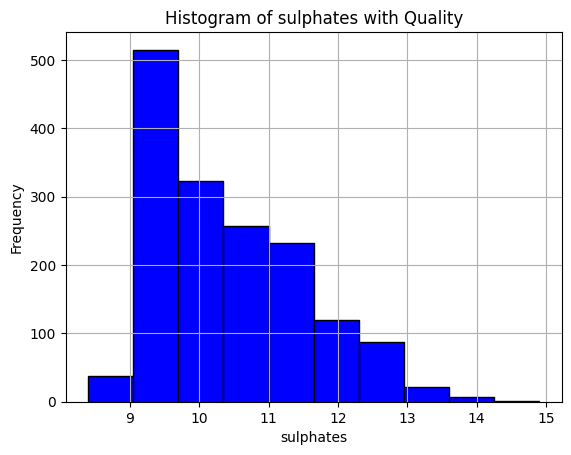

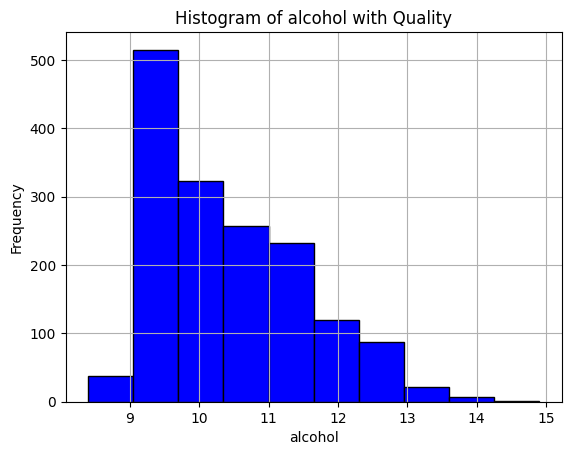

In [0]:
for col_name in wine_df.columns[:-1]:  # Exclude "quality" column
    plt.hist(x_values, bins=10, color='blue', edgecolor='black')
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {col_name} with Quality")
    plt.grid(True)
    plt.show()

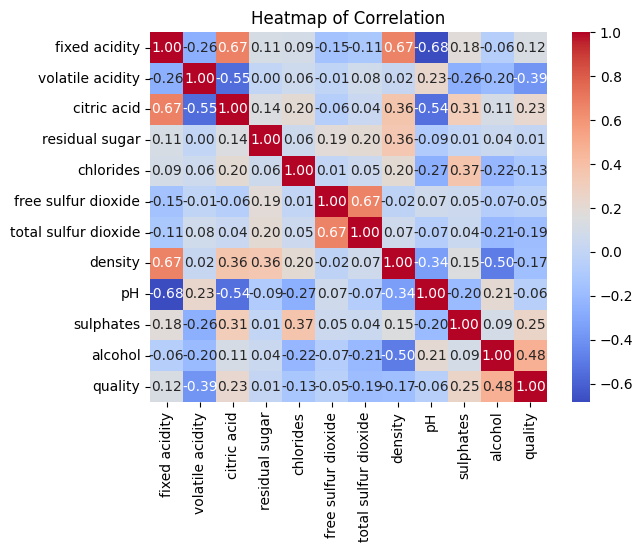

In [0]:
import seaborn as sns
import pandas as pd

pd_df = wine_df.toPandas()

# Create a heatmap plot
sns.heatmap(pd_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Correlation")
plt.show()


## Models

In [0]:
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=123)

#### Linear Regression

In [0]:
from pyspark.ml.regression import LinearRegression

# Initialize Linear Regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="quality")

# Fit the model to the training data
lr_model = lr.fit(train_data)

print("Coefficients: {}".format(lr_model.coefficients))
print("Intercept: {:.2f}".format(lr_model.intercept))

Coefficients: [-6.494148636901253e-14,-6.0240378296392984e-15,6.024645461132682e-15,-1.9768893412906772e-14,-7.96432730544053e-15,7.171580715566798e-15,-9.425740320839197e-15,5.997744496426277e-14,-3.693597213182006e-14,-2.7160044853169473e-15,4.315393627190075e-14,0.8075694397346824]
Intercept: 5.64


In [0]:
# model_path="/mnt/models"
# lr_model.write().overwrite().save(model_path)
# model_name= "Linear_regression"
# # Upload the saved model file to Azure Blob Storage
# with open(model_path, "rb") as data:
#     blob_client = blob_service_client.get_blob_client(container=container_name, blob=model_name)
#     blob_client.upload_blob(data)

In [0]:
# connection_string = "DefaultEndpointsProtocol=https;AccountName=pysparkstorageaccnt;AccountKey=uXDKIkT9KnlL5CSHFqu9auafAdlRXFPDFvWICxSrBvKd6CksPLgNEuzQnlWscUJXmm6kh0xwCx/D+AStSzOnCQ==;EndpointSuffix=core.windows.net"
# blob_service_client = BlobServiceClient.from_connection_string(connection_string)
# blob_client = blob_service_client.get_blob_client(container=container_name, blob=model_name)
# with open(lr_model, "rb") as data:
#     blob_client.upload_blob(data, overwrite=True)

In [0]:
model_path = "/mnt/capstonejs/models/lr_model"
lr_model.write().overwrite().save(model_path)

#### Decision Tree

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="scaled_features", labelCol="quality")
dt_model = dt.fit(train_data)

In [0]:
model_path = "/mnt/capstonejs/models/dt_model"
dt_model.write().overwrite().save(model_path)

In [0]:
dbutils.fs.ls("mnt/capstonejs/dataset/processed")

[FileInfo(path='dbfs:/mnt/capstonejs/dataset/processed/test/', name='test/', size=0, modificationTime=1716287114000),
 FileInfo(path='dbfs:/mnt/capstonejs/dataset/processed/train/', name='train/', size=0, modificationTime=1716287536000)]

## Saving processed data

In [0]:
train_data_path = "/mnt/capstonejs/dataset/processed/train"
test_data_path = "/mnt/capstonejs/dataset/processed/test"

# Save train data as Parquet
train_data.write.format("parquet").mode("overwrite").save(train_data_path)

# Save test data as Parquet
test_data.write.format("parquet").mode("overwrite").save(test_data_path)